# Iris鸢尾花 神经网络模型
- 要求1：一个隐藏层、64个隐藏节点，在测试集输出混淆矩阵；
- 要求2：尝试不同的隐藏层选择和隐藏节点选择，呈现和解释自己的发现；
- 要求3：尝试不通的优化算法（AdaGram、Adadelta、Adam等），呈现和解释自己的发现；
- 要求4：尝试使用随机梯度下降训练模型，并比较使用不同的Batchsize（每次用于训练神经网络的样本数量）时，模型训练的结果。

顺序是：

1.先定义网络:写网络Net的Class，声明网络的实例net=Net()，

2.定义优化器optimizer=optim.xxx(net.parameters()，lr=xxx)，

3.再定义损失函数（自己写class或者直接用官方的，compute_loss=nn.MSELoss()或者其他。

4.在定义完之后，开始一次一次的循环：

    ①先清空优化器里的梯度信息，optimizer.zero_grad();

    ②再将input传入，output=net(input) ，正向传播

    ③算损失，loss=compute_loss(target,output)   ##这里target就是参考标准值GT，需要自己准备，和之前传入的input一一对应

    ④误差反向传播，loss.backward()

    ⑤更新参数，optimizer.step()

这样就实现了一个基本的神经网络。大部分神经网络的训练都可以简化为这个过程，无非是传入的内容复杂，网络定义复杂，损失函数复杂，等等等等。

In [16]:
import numpy as np
import pandas as pd


import torch
from torch import nn
from torch import optim

from collections import Counter
import torch.nn.functional as Fun

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# 数据导入

# 用这个导入前面有个none
# dataTrain = np.loadtxt(open('TrainData.csv'), delimiter=",", skiprows=1)
# dataTest = np.loadtxt(open('TestData.csv', 'r'), delimiter=",", skiprows=1)

dataTrain = pd.read_csv('TrainData.csv').to_numpy()
dataTest = pd.read_csv('TestData.csv').to_numpy()

# 分割数据集
X_train, Y_train = dataTrain[:,:4], dataTrain[:,4]
X_test, Y_test = dataTest[:,:4], dataTest[:,4]

# 转化成张量形式
X_train, Y_train = torch.tensor(X_train, dtype=torch.float32), torch.LongTensor(Y_train) 
X_test, Y_test = torch.tensor(X_test, dtype=torch.float32), torch.LongTensor(Y_test) 

### 做一个网络需要先定义一个Class，继承 nn.Module
（这个是必须的,所以先import torch.nn as nn，nn是一个工具箱，很好用)
### 这个Class里面主要写两个函数，一个是初始化的__init__函数，另一个是forward函数
### __init__里面就是定义卷积层，当然先得super()一下，给父类nn.Module初始化一下。(Python的基础知识）在这个里面主要就是定义卷积层的，比如第一层，我们叫它conv1，把它定义成输入1通道，输出6通道，卷积核5*5的的一个卷积层。conv2同理。神经网络“深度学习”其实主要就是学习卷积核里的参数，像别的不需要学习和改变的，就不用放进去。比如激活函数relu()，你非要放进去也行，再给它起个名字叫myrelu，也是可以的。

### forward里面就是真正执行数据的流动。比如上面的代码，输入的x先经过定义的conv1（这个名字是你自己起的），再经过激活函数F.relu()（这个就不是自己起的名字了，最开始应该先import torch.nn.functional as F，F.relu()是官方提供的函数。当然如果你在__init__里面把relu定义成了我上面说的myrelu，那你这里直接第一句话就成了x=F.max_pool2d(myrelu(self.conv1(x)),2)。下一步的F.max_pool2d池化也是一样的，不多废话了。在一系列流动以后，最后把x返回到外面去。


In [18]:
# 定义BP神经网络
class Net(nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()                          # 给父类nn.Module初始化
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # 定义隐藏层网络
        self.out = torch.nn.Linear(n_hidden, n_output)       # 定义输出层网络
 
    def forward(self, X):                 # 真正执行数据的流动
        X = Fun.relu(self.hidden(X))      # 隐藏层的激活函数,采用relu,也可以采用sigmod,tanh
        X = self.out(X)                   # 输出层不用激活函数 
        return X

In [19]:
# 训练 and 测试
def Prediction(Net, X_train, Y_train, lr):
    # 定义优化器损失函数
    net = Net 
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9) # 优化器选用随机梯度下降方式
    compute_loss = nn.CrossEntropyLoss() # 对于多分类一般采用的交叉熵损失函数,
    
    # 训练数据
    epochs = 500
    for t in range(epochs):
        out = net(X_train)                 # 输入input,输出out
        loss = compute_loss(out, Y_train)     # 输出与label对比
        optimizer.zero_grad()   # 梯度清零
        loss.backward()         # 前馈操作
        optimizer.step()        # 使用梯度优化器

    # 得出结果
    out = net(X_train)  # out是一个计算矩阵，可以用Fun.softmax(out)转化为概率矩阵
    prediction = torch.max(out, 1)[1] # 返回index  0返回原值
    y_pred = prediction.numpy()
    y_true = Y_train.numpy()
    
    # 准确率
    accuracy = float((y_pred == y_true).astype(int).sum()) / float(y_true.size)
    print("莺尾花预测准确率",accuracy)

    c = confusion_matrix(Y_train, y_pred, labels = [0,1,2])
    sns.heatmap(c, annot=True)
    plt.show()

莺尾花预测准确率 0.9666666666666667


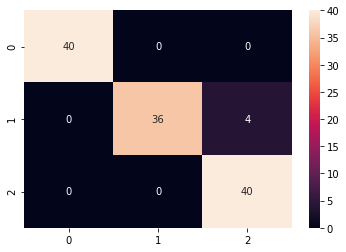

莺尾花预测准确率 1.0


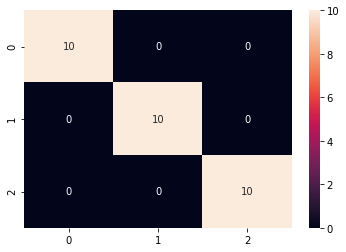

In [20]:
n_feature = 4
n_hidden = 64
n_output = 3
lr = 0.001

Prediction(Net(n_feature, n_hidden, n_output) , X_train, Y_train, lr)
Prediction(Net(n_feature, n_hidden, n_output) , X_test, Y_test, lr)

# 不同隐藏层和隐藏节点的选择：

莺尾花预测准确率 0.9666666666666667


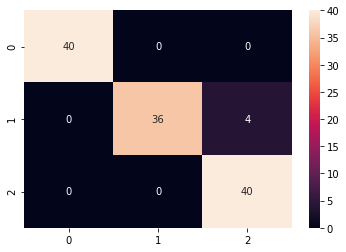

莺尾花预测准确率 1.0


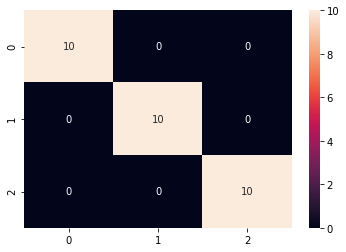

In [23]:
# 不同隐藏层和隐藏节点的选择：
n_feature = 4
n_hidden1 = 100
n_hidden2 = 64
n_output = 3

class Net1(nn.Module):
    def __init__(self, n_feature, n_hidden1, n_hidden2, n_output):
        super(Net1, self).__init__() # 给父类nn.Module初始化
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)   # 定义隐藏层网络
        self.hidden2 = torch.nn.Linear(n_hidden1, n_hidden2)
        self.out = torch.nn.Linear(n_hidden2, n_output)   # 定义输出层网络
 
    def forward(self, X): # 真正执行数据的流动
        X = Fun.relu(self.hidden2(Fun.relu(self.hidden1(X))))     # 隐藏层的激活函数,采用relu,也可以采用sigmod,tanh
        X = self.out(X)                   # 输出层不用激活函数 
        return X


Prediction(Net1(n_feature, n_hidden1, n_hidden2, n_output) , X_train, Y_train, lr)
Prediction(Net1(n_feature, n_hidden1, n_hidden2, n_output) , X_test, Y_test, lr)

莺尾花预测准确率 0.975


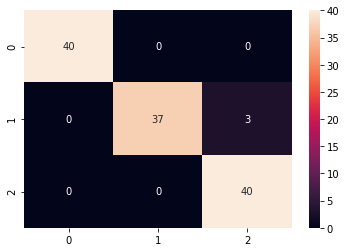

莺尾花预测准确率 1.0


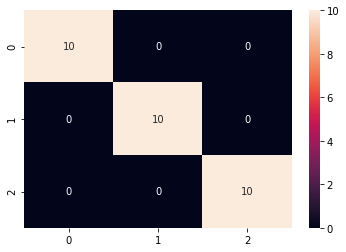

In [24]:
# 不同隐藏层和隐藏节点的选择：
n_feature = 4
n_hidden1 = 256 # 还试了 780和256等 组合，训练集最高达到0.98
n_hidden2 = 144
n_output = 3

class Net1(nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net1, self).__init__() # 给父类nn.Module初始化
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)   # 定义隐藏层网络
        self.hidden2 = torch.nn.Linear(n_hidden1, n_hidden2)
        self.out = torch.nn.Linear(n_hidden2, n_output)   # 定义输出层网络
 
    def forward(self, X): # 真正执行数据的流动
        X = Fun.relu(self.hidden2(Fun.relu(self.hidden1(X))))     # 隐藏层的激活函数,采用relu,也可以采用sigmod,tanh
        X = self.out(X)                   # 输出层不用激活函数 
        return X


Prediction(Net1(n_feature, n_hidden, n_output) , X_train, Y_train, lr)
Prediction(Net1(n_feature, n_hidden, n_output) , X_test, Y_test, lr)

# 不同的优化算法

In [25]:
# 训练 and 测试
def Prediction1(Net, X_train, Y_train, lr, optim_f):
    # 定义优化器损失函数
    net = Net 
    optimizer = optim_f(net.parameters(), lr=lr) # 优化器选用随机梯度下降方式
    compute_loss = nn.CrossEntropyLoss() # 对于多分类一般采用的交叉熵损失函数,
    
    # 训练数据
    epochs = 500
    for t in range(epochs):
        out = net(X_train)                 # 输入input,输出out
        loss = compute_loss(out, Y_train)     # 输出与label对比
        optimizer.zero_grad()   # 梯度清零
        loss.backward()         # 前馈操作
        optimizer.step()        # 使用梯度优化器

    # 得出结果
    out = net(X_train)  # out是一个计算矩阵，可以用Fun.softmax(out)转化为概率矩阵
    prediction = torch.max(out, 1)[1] # 返回index  0返回原值
    y_pred = prediction.numpy()
    y_true = Y_train.numpy()
    
    # 准确率
    accuracy = float((y_pred == y_true).astype(int).sum()) / float(y_true.size)
    print("莺尾花预测准确率",accuracy)

    c = confusion_matrix(Y_train, y_pred, labels = [0,1,2])
    sns.heatmap(c, annot=True)
    plt.show()

莺尾花预测准确率 0.75


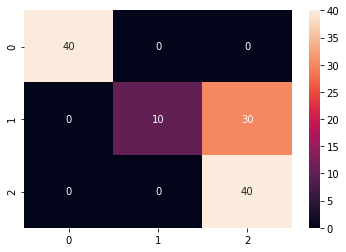

莺尾花预测准确率 0.6333333333333333


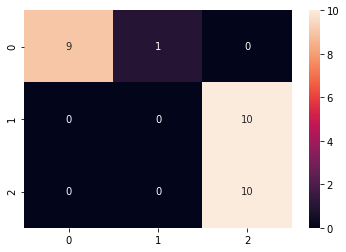

莺尾花预测准确率 0.975


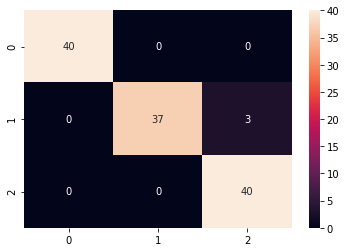

莺尾花预测准确率 1.0


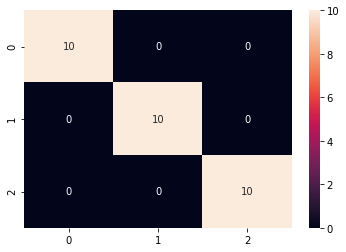

In [26]:
# Adagrad

Prediction1(Net(n_feature, n_hidden, n_output) , X_train, Y_train, lr, optim.Adagrad)
Prediction1(Net(n_feature, n_hidden, n_output) , X_test, Y_test, lr, optim.Adagrad)

lr = 0.01
Prediction1(Net(n_feature, n_hidden, n_output) , X_train, Y_train, lr, optim.Adagrad)
Prediction1(Net(n_feature, n_hidden, n_output) , X_test, Y_test, lr, optim.Adagrad)

# 结论：去掉momentum=0.9 后用原来的lr=0.001准确率还降低了，但改成0.01就好了

莺尾花预测准确率 0.3333333333333333


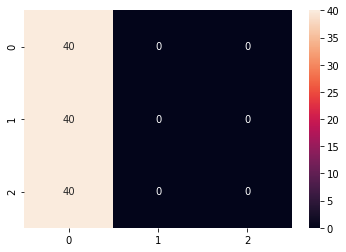

莺尾花预测准确率 0.06666666666666667


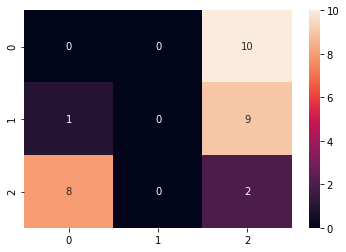

莺尾花预测准确率 0.6666666666666666


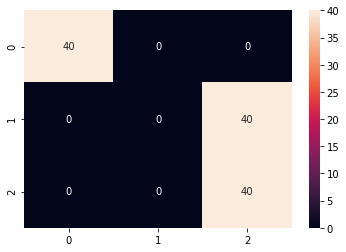

莺尾花预测准确率 0.7


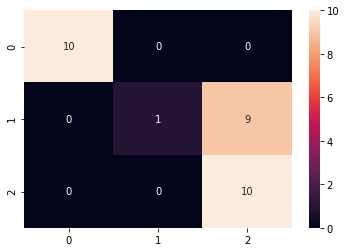

莺尾花预测准确率 0.975


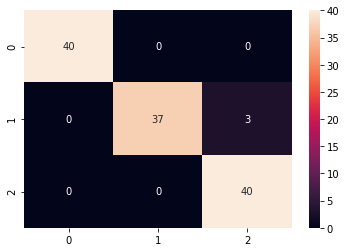

莺尾花预测准确率 1.0


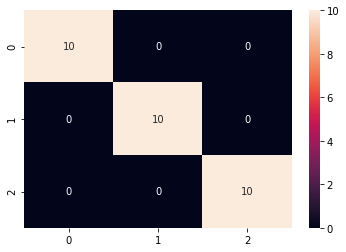

莺尾花预测准确率 0.9583333333333334


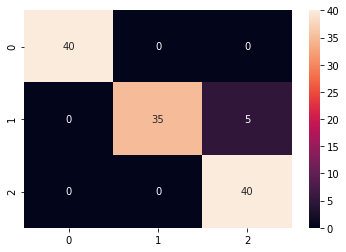

莺尾花预测准确率 1.0


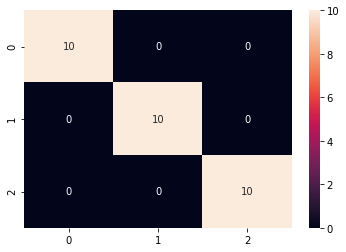

In [28]:
# Adadelta

lr = 0.001
Prediction1(Net(n_feature, n_hidden, n_output) , X_train, Y_train, lr, optim.Adadelta)
Prediction1(Net(n_feature, n_hidden, n_output) , X_test, Y_test, lr, optim.Adadelta)

lr = 0.01
Prediction1(Net(n_feature, n_hidden, n_output) , X_train, Y_train, lr, optim.Adadelta)
Prediction1(Net(n_feature, n_hidden, n_output) , X_test, Y_test, lr, optim.Adadelta)

lr = 0.1 # 合适
Prediction1(Net(n_feature, n_hidden, n_output) , X_train, Y_train, lr, optim.Adadelta)
Prediction1(Net(n_feature, n_hidden, n_output) , X_test, Y_test, lr, optim.Adadelta)

lr = 0.5
Prediction1(Net(n_feature, n_hidden, n_output) , X_train, Y_train, lr, optim.Adadelta)
Prediction1(Net(n_feature, n_hidden, n_output) , X_test, Y_test, lr, optim.Adadelta)

# 结论： 学习域约低效果越差,但学习域过高效果也会变差

# 使用随机梯度下降模型

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.datasets.samples_generator import make_blobs

##生产数据
X, Y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.60)

##训练数据
clf = SGDClassifier(loss="hinge", alpha=0.01)
clf.fit(X, Y)

## 绘图
xx = np.linspace(-1, 5, 10)
yy = np.linspace(-1, 5, 10)

##生成二维矩阵
X1, X2 = np.meshgrid(xx, yy)
##生产一个与X1相同形状的矩阵
Z = np.empty(X1.shape)
##np.ndenumerate 返回矩阵中每个数的值及其索引
for (i, j), val in np.ndenumerate(X1):
    x1 = val
    x2 = X2[i, j]
    p = clf.decision_function([[x1, x2]]) ##样本到超平面的距离
    Z[i, j] = p[0]
levels = [-1.0, 0.0, 1.0]
linestyles = ['dashed', 'solid', 'dashed']
colors = 'k'
##绘制等高线：Z分别等于levels
plt.contour(X1, X2, Z, levels, colors=colors, linestyles=linestyles)
##画数据点
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired,
            edgecolor='black', s=20)
plt.axis('tight')
plt.show()

### 这个Net的Class定义主要要注意两点。

### 第一：是注意前后输出通道和输入通道的一致性。不能第一个卷积层输出4通道，第二个输入6通道，这样就会报错。

### 第二：它和我们常规的python的class还有一些不同，发现了没有？我们该怎么用这个Net呢？

先定义一个Net的实例（毕竟Net只是一个类不能直接传参数，output=Net（input）当然不行）

In [ ]:
net=Net()

这样我们就可以往里传x了，假设你已经有一个要往神经网络的输入的数据“input"（这个input应该定义成tensor类型，怎么定义tensor那就自己去看看书了。另外pytorch三点几版本的你还得把它弄成Variable类型，4.0以后的就不需要了）

在传入的时候，是:

In [ ]:
# b=torch.from_numpy( a )
output=net(input)

有点奇怪。好像常规python一般向class里面传入一个数据x，在class的定义里面，应该是把这个x作为形参传入__init__函数里的，而在上面的定义中，x作为形参是传入forward函数里面的。

其实也不矛盾，因为你定义net的时候，是net=Net()，并没有往里面传入参数。如果你想初始化的时候按需传入，就把需要的传入进去。只是x是神经网络的输入，但是并非是初始化需要的，初始化一个网络，必须要有输入数据吗？未必吧。只是在传入网络的时候，会自动认为你这个x是喂给forward里面的。

在网络定义好以后，就涉及到传入参数，算误差，反向传播，更新权重…确实很容易记不住这些东西的格式和顺序。

传入的方式上面已经介绍了，相当于一次正向传播，把一路上各层的输入x都算出来了。

想让神经网络输出的output跟你期望的ground truth差不多，那就是不断减小二者间的差异，这个差异是你自己定义的，也就是目标函数（object function）或者就是损失函数。如果损失函数loss趋近于0，那么自然就达到目的了。

损失函数loss基本上没法达到0，但是希望能让它达到最小值，那么就是希望它能按照梯度进行下降。梯度下降的公式，大家应该都很熟悉，不熟悉的话，建议去看一下相关的理论。谁喜欢看公式呢？所以我这里不讲。

只是你的输入是由你来决定的，那神经网络能学习和决定什么呢？自然它只能决定每一层卷积层的权重。所以神经网络只能不停修改权重，比如y=wx+b，x是你给的，它只能改变w，b让最后的输出y尽可能接近你希望的y值，这样损失loss就越来越小。

如果loss对于卷积层里面的参数W的偏导数接近0了，不就意味着到达了一个极小值吗？而l在你的loss计算方式已经给定的情况下，loss对于w的偏导数的减小，其实只能通过更新参数卷积层参数W来实现（别的它决定不了啊，都是你输入和提供的）。

所以，通过下述方式实现对W的更新：（注意这些编号，下面还要提）

【1】 先算loss对于输入x的偏导，（当然网络好几层，这个x指的是每一层的输入，而不是最开始的输入input）

【2】 对【1】的结果再乘以一个步长（这样就相当于是得到一个对参数W的修改量）

【3】 用W减掉这个修改量，完成一次对参数W的修改。

说的不太严谨，但是大致意思是这样的。这个过程你可以手动实现，但是大规模神经网络怎么手动实现？那是不可能的事情。所以我们要利用框架pytorch和工具箱torch.nn。

所以要定义损失函数，以MSEloss为例：
明显它也是个类，不能直接传入输入数据，所以直接loss=nn.MSEloss（target，output）是不对的。需要把这个函数赋一个实例，叫成compute_loss。之后就可以把你的神经网络的输出，和标准答案target传入进去：

In [ ]:
compute_loss=nn.MSELoss()
loss=compute_loss(target,output)

算出loss，下一步就是反向传播：

In [ ]:
loss.backward()

这一步其实就是把【1】给算完了，得到对参数W一步的更新量，算是一次反向传播。

这里就注意了，loss.backward()是啥玩意？如果是自己的定义的loss（比如你就自己定义了个def loss（x，y）：return y-x ）这样肯定直接backward会出错。所以应当用nn里面提供的函数。当然搞深度学习不可能只用官方提供的loss函数，所以如果你要想用自己的loss函数，必须也把loss定义成上面Net的样子（不然你的loss不能反向传播，这点要注意，注：这点是以前写的，很久之前的版本不行，现在都可以了，基本不太需要这样了），也是继承nn.Module，把传入的参数放进forward里面，具体的loss在forward里面算，最后return loss。__init__()就空着，写个super().__init__就行了。

在反向传播之后，第【2】和第【3】怎么实现？就是通过优化器来实现。让优化器来自动实现对网络权重W的更新。

所以在Net定义完以后，需要写一个优化器的定义（选SGD方式为例）：

In [ ]:

optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

同样，优化器也是一个类，先定义一个实例optimizer，然后之后会用。注意在optimizer定义的时候，需要给SGD传入了net的参数parameters，这样之后优化器就掌握了对网络参数的控制权，就能够对它进行修改了。传入的时候把学习率lr也传入了。

在每次迭代之前，先把optimizer里存的梯度清零一下（因为W已经更新过的“更新量”下一次就不需要用了）

In [ ]:
optimizer.zero_grad()

在loss.backward()反向传播以后，更新参数：

In [ ]:
optimizer.step()